In [72]:
!pip install lazypredict

In [73]:
import numpy as np
import pandas as pd
import kagglehub
import joblib

from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from xgboost import XGBClassifier


In [74]:
path = kagglehub.dataset_download("uom190346a/sleep-health-and-lifestyle-dataset")
print(path)

/kaggle/input/sleep-health-and-lifestyle-dataset


# Data Exploration

In [75]:
df = pd.read_csv(path + "/Sleep_health_and_lifestyle_dataset.csv")
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.10,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.20,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.20,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.90,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.90,4,30,8,Obese,140/90,85,3000,Sleep Apnea


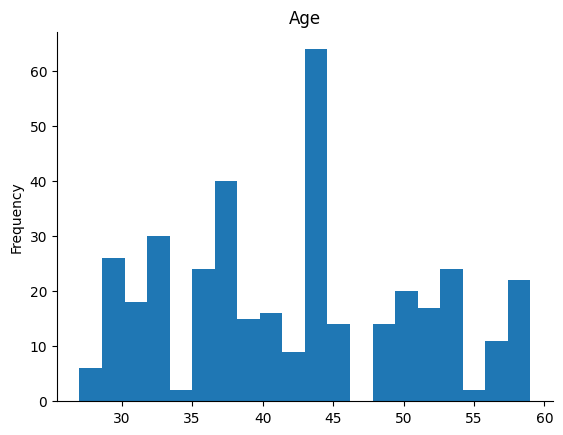

In [76]:
# @title Age

from matplotlib import pyplot as plt
df['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

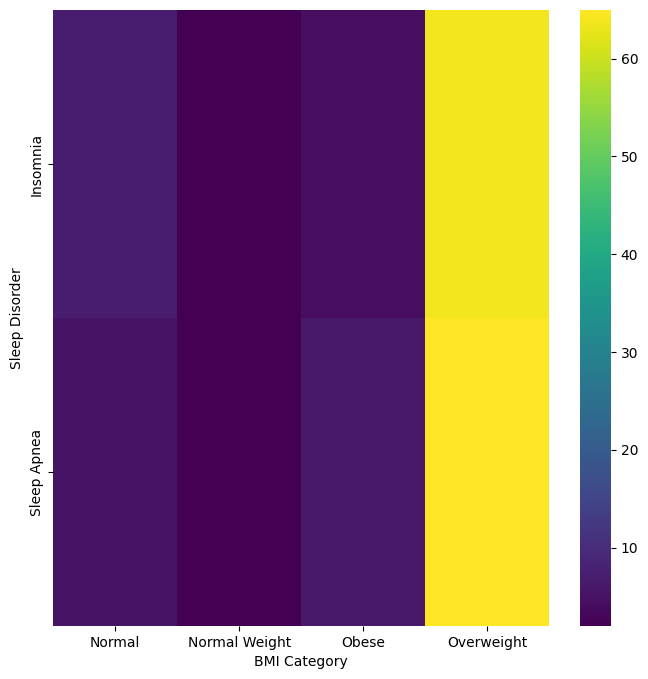

In [77]:
# @title BMI Category vs Sleep Disorder

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Sleep Disorder'].value_counts()
    for x_label, grp in df.groupby('BMI Category')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('BMI Category')
_ = plt.ylabel('Sleep Disorder')

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [79]:
unique_sleep_disorders = df["Sleep Disorder"].unique()
unique_sleep_disorders

array([nan, 'Sleep Apnea', 'Insomnia'], dtype=object)

In [80]:
vc = df["BMI Category"].value_counts()
print(vc.index.values)
print(vc)

['Normal' 'Overweight' 'Normal Weight' 'Obese']
BMI Category
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: count, dtype: int64


In [81]:
df.isna().sum()

,0
Person ID,0
Gender,0
Age,0
Occupation,0
Sleep Duration,0
Quality of Sleep,0
Physical Activity Level,0
Stress Level,0
BMI Category,0
Blood Pressure,0


In [82]:
df.dropna(inplace=True)

# Data Preprocessing

In [83]:
label_encoder = LabelEncoder()

encode_columns = ["Gender", "Sleep Disorder"]
overweight_values = {"obese", "overweight"}

for column in encode_columns:
    df[column] = label_encoder.fit_transform(df[column])

# Drop these columns as we do not need them / don't have them in our model
# We may want these later, but for the purpose of a PoC, we will avoid these
drop_columns = ["Person ID", "Occupation", "Blood Pressure"]
df.drop(drop_columns, axis=1, inplace=True)

df["BMI Category"] = df["BMI Category"].apply(lambda x: 1 if x.lower() in overweight_values else 0)

df.head()

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder
3,1,28,5.90,4,30,8,1,85,3000,1
4,1,28,5.90,4,30,8,1,85,3000,1
5,1,28,5.90,4,30,8,1,85,3000,0
6,1,29,6.30,6,40,7,1,82,3500,0
16,0,29,6.50,5,40,7,0,80,4000,1


# Model

In [84]:
X = df.drop("BMI Category", axis=1)
y = df["BMI Category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [85]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifier = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = classifier.fit(X_train_scaled, X_test_scaled, y_train, y_test)

models

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 103, number of negative: 13
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 116, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.887931 -> initscore=2.069780
[LightGBM] [Info] Start training from score 2.069780
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,1.00,1.00,1.00,1.00,0.24
BaggingClassifier,1.00,1.00,1.00,1.00,0.09
CalibratedClassifierCV,1.00,1.00,1.00,1.00,0.08
DecisionTreeClassifier,1.00,1.00,1.00,1.00,0.02
ExtraTreesClassifier,1.00,1.00,1.00,1.00,0.29
LogisticRegression,1.00,1.00,1.00,1.00,0.05
LinearSVC,1.00,1.00,1.00,1.00,0.04
LinearDiscriminantAnalysis,1.00,1.00,1.00,1.00,0.03
LabelSpreading,1.00,1.00,1.00,1.00,0.02


In [86]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb',    XGBClassifier(random_state=42)),
])

pipe.fit(X_train, y_train)


# Save pipeline (we don't need to save scaler now and can use unscaled data)
joblib.dump(pipe, '../model/xgb_risk_model.joblib')


['xgb_risk_model.joblib']

Accuracy:       1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        36

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39

Confusion Matrix:
 [[ 3  0]
 [ 0 36]]
ROC AUC Score:  1.0


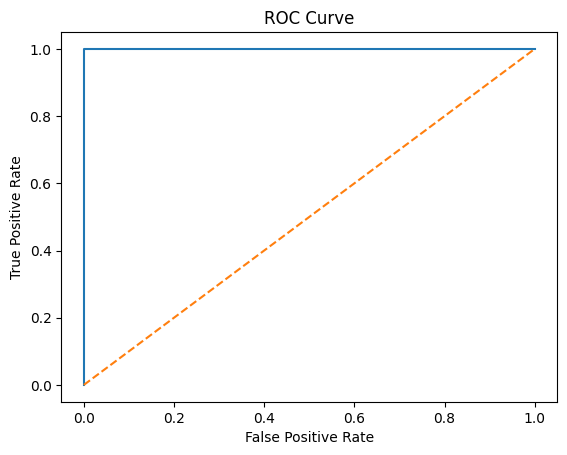

In [87]:
y_pred = pipe.predict(X_test)

print("Accuracy:      ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

y_proba = pipe.predict_proba(X_test)[:,1]
print("ROC AUC Score: ", roc_auc_score(y_test, y_proba))

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


In [88]:
scoring = [
    'accuracy',
    'precision_macro',
    'recall_macro',
    'f1_macro',
    'roc_auc'
]

cv_results = cross_validate(
    pipe,
    X, y,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

# Average across folds
for metric in scoring:
    mean_score = cv_results[f'test_{metric}'].mean()
    print(f"{metric:>15}: {mean_score:.3f}")


       accuracy: 0.845
precision_macro: 0.792
   recall_macro: 0.739
       f1_macro: 0.710
        roc_auc: 0.724


# Synthetic Data Backed Model
The dataset only has values for adults and none for children which is not ideal for addressing the problem of childhood obesity.

A "fix" for this is to create a synthetic dataset with the age rages we're interested in and save this model as well. We can use either of these to test different behaviors of the coaching engine, but we would want to use a longitudinal dataset of children before going live with this project.

In [89]:
synth_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb',    XGBClassifier(random_state=42)),
])

Xr, yr = make_classification(
    n_samples=2000,
    n_features=X.shape[1],
    n_informative=5,
    n_redundant=2,
    n_classes=len(y.unique()),
    flip_y=0.01,
    random_state=42
)

X_synth = pd.DataFrame(Xr, columns=X.columns)

# force ages 2–19
X_synth['Age'] = np.random.randint(2, 20, size=len(X_synth))

# Combine with real data
X_combined = pd.concat([X, X_synth], ignore_index=True)
y_combined = np.concatenate([y, yr])
X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.25, random_state=42)

synth_pipe.fit(X_train, y_train)

# save piepline
joblib.dump(synth_pipe, '../model/xgb_synth_risk_model.joblib')

['xgb_synth_risk_model.joblib']

Metrics for synthetic aided model
Accuracy:       0.9332096474953617
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       261
           1       0.93      0.94      0.94       278

    accuracy                           0.93       539
   macro avg       0.93      0.93      0.93       539
weighted avg       0.93      0.93      0.93       539

Confusion Matrix:
 [[242  19]
 [ 17 261]]
ROC AUC Score:  0.5272747319385871


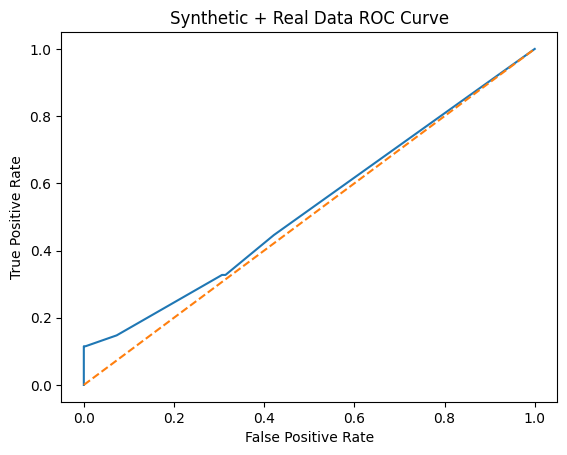

In [90]:
y_pred = synth_pipe.predict(X_test)

print("Metrics for synthetic aided model")
print("Accuracy:      ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

y_proba = pipe.predict_proba(X_test)[:,1]
print("ROC AUC Score: ", roc_auc_score(y_test, y_proba))

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Synthetic + Real Data ROC Curve")
plt.show()

In [92]:
scoring = [
    'accuracy',
    'precision_macro',
    'recall_macro',
    'f1_macro',
    'roc_auc'
]

cv_results = cross_validate(
    synth_pipe,
    X_combined, y_combined,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

# Average across folds
for metric in scoring:
    mean_score = cv_results[f'test_{metric}'].mean()
    print(f"{metric:>15}: {mean_score:.3f}")


       accuracy: 0.902
precision_macro: 0.903
   recall_macro: 0.901
       f1_macro: 0.901
        roc_auc: 0.967
